In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio

from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import  matplotlib.markers as mark


from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import cm

import os
from os.path import expanduser

import pickle

import torch
# from tqdm import tqdm

# from rnn_hierarchical_withTau import RNN_stack

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
ft = 14
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': ft})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"


save_fig_path = expanduser("~") + '/research/data/projects/rnn_timescales/neurips_23/'

col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

# Load data

In [3]:
num_neurons = 500
NET_SIZE = [num_neurons]

INPUT_SIZE = 1
NUM_CLASSES = 2
BIAS = True
NUM_READOUT_HEADS = 100
TRAIN_TAU = True


## load taus

In [4]:
def load_taus(path, network_name, N):
    
    with open(path + network_name + '_N' + str(N) + '_acs_taus.pkl', 'rb') as f:
        data = pickle.load(f)
    tau_eff = data['taus_net']
    selected_models = data['selected_models']
    trained_taus = data['taus_trained']
    single_acs = data['ac_all']
    ac_pop = data['ac_pop']
    
            
#     tau_eff = np.array(tau_eff)
    return tau_eff, selected_models, trained_taus, single_acs, ac_pop 


In [5]:
def compute_mean_std_tau_eff(path, curriculum_type, task, net_ids, N_range):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    
    for i, N in enumerate(N_range):
        
        train_taus_all = []
        eff_taus_all = []
        eff_taus_net_avg = np.zeros(len(net_ids))
        eff_taus_net_std = np.zeros(len(net_ids))
        
        for j, net_id in enumerate(net_ids):
            
            network_name = curriculum_type + '_' + task + '_network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus(path, network_name, N)
            tau_eff = tau_eff[(tau_eff>1)]

            eff_taus_net_avg[j] = np.mean(tau_eff)
            eff_taus_net_std[j] = np.std(tau_eff)

        tau_mean_mean[i] = np.mean(eff_taus_net_avg)
        tau_std_mean[i] = np.std(eff_taus_net_avg)
        tau_mean_std[i] = np.mean(eff_taus_net_std)
        tau_std_std[i] = np.std(eff_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std


def compute_mean_std_tau_train(path, curriculum_type, task, net_ids, N_range):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        train_taus_all = []
        train_taus_net_avg = np.zeros(len(net_ids))
        train_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            
            network_name = curriculum_type + '_' + task + '_network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus(path, network_name, N)

            train_taus_net_avg[j] = np.mean(trained_taus)
            train_taus_net_std[j] = np.std(trained_taus)

        tau_mean_mean[i] = np.mean(train_taus_net_avg)
        tau_std_mean[i] = np.std(train_taus_net_avg)
        tau_mean_std[i] = np.mean(train_taus_net_std)
        tau_std_std[i] = np.std(train_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

In [6]:
def plot_shade(x, mean, std, color):
    ax.fill_between(
        x,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3,
    )

In [17]:
path = '../../results/'
curriculum_type = 'single'
duplicate = 5
task = f'parity_duplicate{duplicate}_tau{float(duplicate)}'
net_ids = [1]  # [0, 1, 2, 3]
N_range = np.arange(2, 30, 5)

tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(path, curriculum_type, task, net_ids, N_range)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


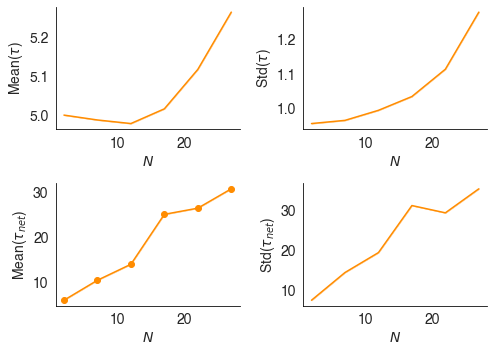

In [18]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 13*cm))


alpha_dot = 0.6
w = 0.35 #width of mean line
ms = 8
lw = 2

x_text = -.4
y_text = 1.1

x_noise = 0.05
c_singlehead = '#D48A6A'
c_multihead = '#489174'
c_new = 'darkorange'
c_old = 'deepskyblue'


ms = 3
lw = 1.5
elw = 1.5

y1 = .9
y2 = 2


# path = './timescales_single_nocurr_from_Tims_computer/'
# curriculum_type = 'single'
# task = 'nocurr_parity_mod_relu'
# net_ids =  np.arange(1,4)
# N_range = np.arange(3, 21)


# tau_trained
tau_mean_mean_train, tau_mean_std_train,  tau_std_mean_train, tau_std_std_train  =\
compute_mean_std_tau_train(path, curriculum_type, task, net_ids, N_range)


ax = plt.subplot(221)
plt.plot(N_range, tau_mean_mean_train, color = c_new, lw = lw)
plot_shade(N_range, tau_mean_mean_train, tau_std_mean_train, c_new)
plt.ylabel(r'Mean($\tau$)')
plt.xlabel(r'$N$')
plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,.9))



ax = plt.subplot(222)
plt.plot(N_range, tau_mean_std_train, color = c_new, label = '$ReLU')
plot_shade(N_range, tau_mean_std_train, tau_std_std_train, c_new)
plt.ylabel(r'Std($\tau$)')
plt.xlabel(r'$N$')


# tau_NET
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(path, curriculum_type, task, net_ids, N_range)


ax = plt.subplot(223)
plt.plot(N_range, tau_mean_mean, marker='o', color = c_new, lw = lw)
plot_shade(N_range, tau_mean_mean, tau_std_mean, c_new)
plt.ylabel(r'Mean($\tau_{net}$)')
plt.xlabel(r'$N$')
plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,.9))



ax = plt.subplot(224)
plt.plot(N_range, tau_mean_std, color = c_new, label = '$ReLU')
plot_shade(N_range, tau_mean_std, tau_std_std, c_new)
plt.ylabel(r'Std($\tau_{net}$)')
plt.xlabel(r'$N$')



fig.tight_layout()

sns.despine()

plt.savefig('No Curriculum timescales.pdf')


In [ ]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 6.5*cm))


alpha_dot = 0.6
w = 0.35 #width of mean line
ms = 8
lw = 2

x_text = -.4
y_text = 1.1

x_noise = 0.05
c_singlehead = '#D48A6A'
c_multihead = '#489174'
c_new = 'darkorange'
c_old = 'deepskyblue'


ms = 3
lw = 1.5
elw = 1.5

y1 = .9
y2 = 2


path = './timescales_single_nocurr_from_Tims_computer/'
curriculum_type = 'single'
task = 'nocurr_parity_mod_relu'
net_ids =  np.arange(1,4)
N_range = np.arange(3, 21)


# tau_trained
tau_mean_mean_train, tau_mean_std_train,  tau_std_mean_train, tau_std_std_train  =\
compute_mean_std_tau_train(path, curriculum_type, task, net_ids, N_range)

# tau_NET
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(path, curriculum_type, task, net_ids, N_range)

ax = plt.subplot(121)
plt.plot(N_range, tau_mean_mean_train, color = c_new, lw = lw)
plot_shade(N_range, tau_mean_mean_train, tau_mean_std_train, c_new)
plt.ylabel(r'$\tau$')
plt.xlabel(r'$N$')
plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,.9))



ax = plt.subplot(122)
plt.plot(N_range, tau_mean_mean, color = c_new, lw = lw)
plot_shade(N_range, tau_mean_mean, tau_mean_std, c_new)
plt.ylabel(r'$\tau_{net}$')
plt.xlabel(r'$N$')
plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,.9))



fig.tight_layout()

sns.despine()

plt.savefig('taus.pdf')



In [ ]:
path = './Sina_results/'
curriculum_type = 'cumulative'
task = 'nocurr_parity_mod_relu'
net_ids = [0, 1, 2, 3]
N_range = np.arange(100, 101)


tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(path, curriculum_type, task, net_ids, N_range)

tau_mean_mean

In [ ]:
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(path, curriculum_type, task, net_ids, N_range)

tau_mean_mean